# Step 1: Load Your Dataset and Prepare the Environment
Set up our workspace with the Iris dataset.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Load the Breast Cancer Wisconsin dataset
dataset = load_breast_cancer()
X, y = dataset.data, dataset.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Display dataset information
print("Dataset Overview:")
print("-----------------")
print(f"Features: {dataset.feature_names}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Dataset Overview:
-----------------
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Training samples: 455
Testing samples: 114


# Step 2: Select Your Base Models
Create a diverse ensemble of base models.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Define base models
base_models = [
    ('decision_tree', DecisionTreeClassifier(max_depth=4, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('support_vector_machine', SVC(probability=True, random_state=42))
]

# Train and evaluate individual base models
base_accuracies = {}
for name, model in base_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    base_accuracies[name] = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {base_accuracies[name]:.3f}")

decision_tree Accuracy: 0.947
random_forest Accuracy: 0.956
support_vector_machine Accuracy: 0.947


# Step 3: Set Up the Stacking Architecture
Combine base models with a meta-learner.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Meta model
meta_model = LogisticRegression(random_state=42)

# Create stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    stack_method='predict_proba'
)

# Step 4: Train Your Stacking Model
Train the complete stacking ensemble.

In [ ]:
# Fit the stacking classifier
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('decision_tree',
                                DecisionTreeClassifier(max_depth=4,
                                                       random_state=42)),
                               ('random_forest',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('support_vector_machine',
                                SVC(probability=True, random_state=42))],
                   final_estimator=LogisticRegression(random_state=42),
                   stack_method='predict_proba')

# Step 5: Evaluate the Stacking Performance
Assess how well our ensemble performs.


Stacking Model Accuracy: 0.956


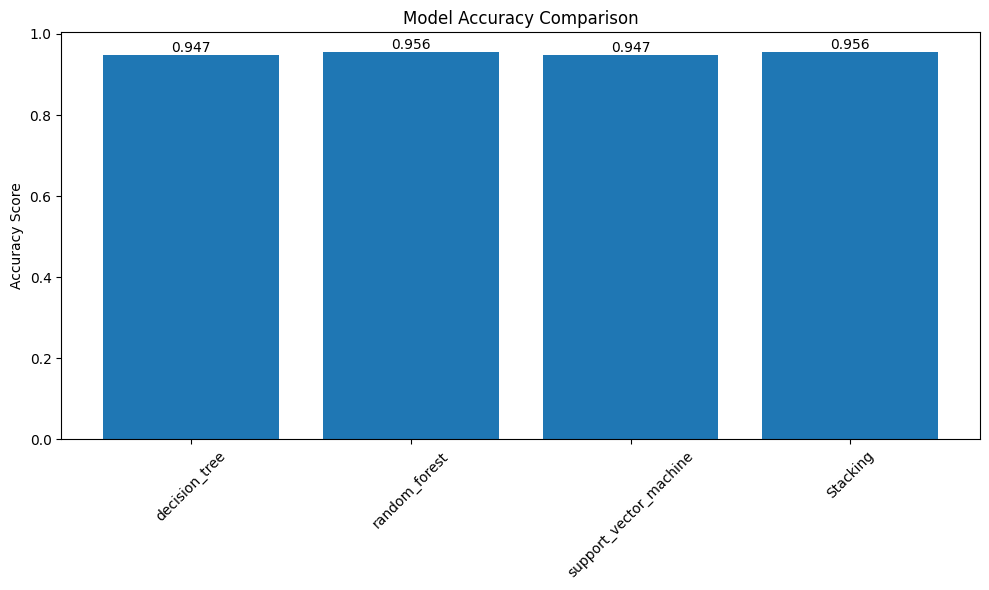

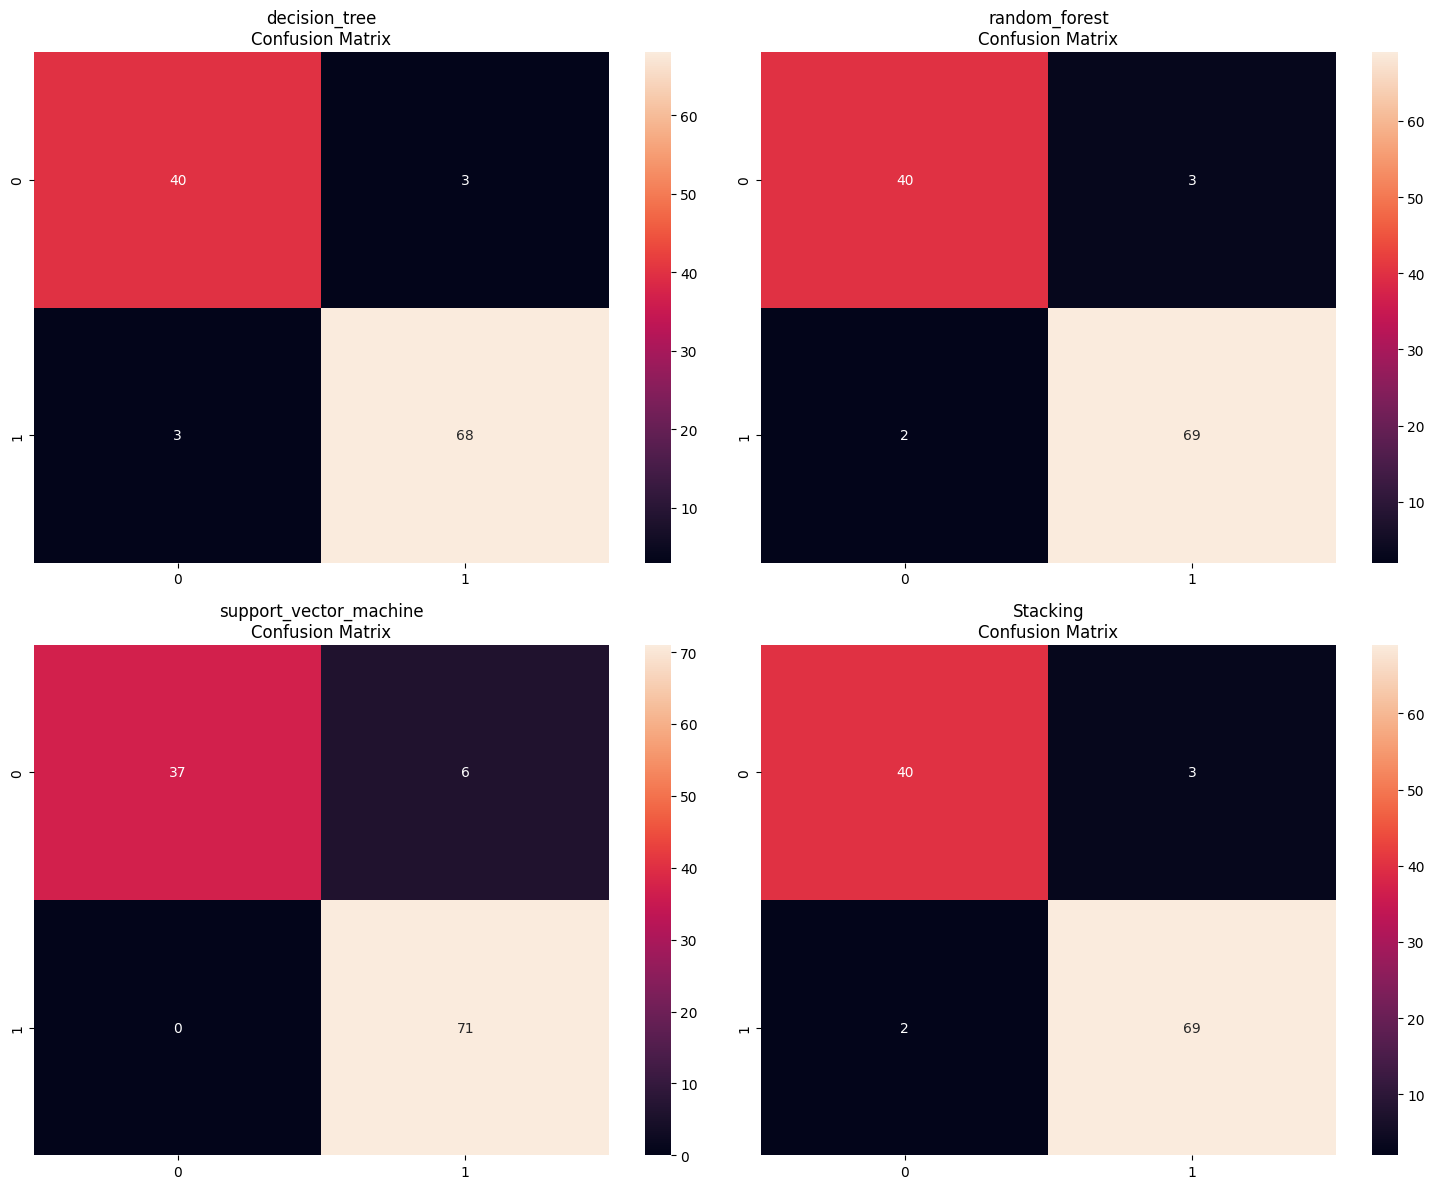

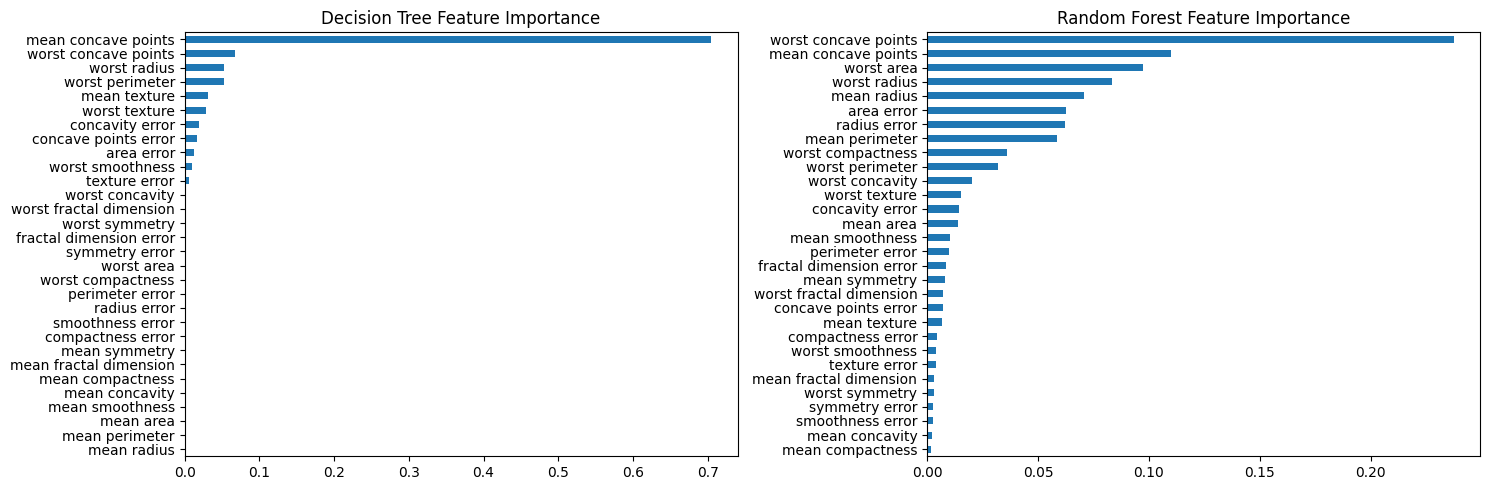

In [ ]:
# Make predictions and calculate accuracy
y_pred = stacking_clf.predict(X_test)
stacking_accuracy = accuracy_score(y_test, y_pred)
print(f"\nStacking Model Accuracy: {stacking_accuracy:.3f}")

# Visualize model comparison
# =====================================

def plot_model_comparison():
    # Combine accuracies
    accuracies = {**base_accuracies, 'Stacking': stacking_accuracy}

    plt.figure(figsize=(10, 6))
    bars = plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy Score')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_model_comparison()



In [ ]:
# Visualize confusion matrices
# =====================================

def plot_confusion_matrices():
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    # Plot for base models
    for idx, (name, model) in enumerate(base_models):
        cm = confusion_matrix(y_test, model.predict(X_test))
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx])
        axes[idx].set_title(f'{name}\nConfusion Matrix')

    # Plot for stacking
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[3])
    axes[3].set_title('Stacking\nConfusion Matrix')

    plt.tight_layout()
    plt.show()

plot_confusion_matrices()



In [ ]:
# Feature importance analysis
# =====================================

def plot_feature_importance():
    # Get feature importance from tree-based models
    dt_importance = dict(zip(dataset.feature_names,
                           base_models[0][1].feature_importances_))
    rf_importance = dict(zip(dataset.feature_names,
                           base_models[1][1].feature_importances_))

    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Decision Tree importance
    pd.Series(dt_importance).sort_values().plot(kind='barh', ax=ax1)
    ax1.set_title('Decision Tree Feature Importance')

    # Random Forest importance
    pd.Series(rf_importance).sort_values().plot(kind='barh', ax=ax2)
    ax2.set_title('Random Forest Feature Importance')

    plt.tight_layout()
    plt.show()

plot_feature_importance()